First we import some packages from pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "true"

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## Read the data file in
Use parameter "parse_dates" to set column "utc_timestamp" and "cet_cest_timestamp" as date data column

Decoding the date data automatically by setting "infer_datatime_format" as true

Setting "low_memory" as false to tell pandas the file we read in is a big one

In [5]:
energy_data = pd.read_csv("household_data_15min_singleindex.csv", #iterator=True,  chunksize=1000,
                    parse_dates=["utc_timestamp", "cet_cest_timestamp"], infer_datetime_format=True, low_memory=False)

## Data washing
discard all columns except "DE_KN_residential3_circulation_pump",
this is because this column has the most valid data to train

copy the data in this column into fv_data by operation ".loc[o:]"

In [6]:
fv_col = "DE_KN_residential3_circulation_pump"
fv_data = energy_data[fv_col].loc[0:]

Since the datas are cumulative values,
here we do a differentiation to get the runtime comsuption value (per quarter)

In [7]:
src_data_ls = []
for i in range(len(fv_data) - 1):
    if not np.isnan(fv_data[i]) and not np.isnan(fv_data[i+1]):
        src_data_ls.append(fv_data[i+1] - fv_data[i])

convert the list type data into numpy array
and reshape it to two dimensions

In [8]:
src_data = np.array(src_data_ls).reshape(-1, 1)
len(src_data), src_data.shape

(132838, (132838, 1))

we expect our model can predict the future energy consumption,
given the energy consumption one day before.
thus, we set the look back value as $24\times 4$

Scaling the data into 0 to 1 by:
$$
d_{new} = \frac{d_{old} - d_{min}}{d_{max} - d_{min}}
$$
And then prepare the data as **data_in** with each item contains lookback history datas
and **data_out** with each item contains the prediction data associated to the history datas

In [9]:
lookback = 24 * 4
data_in = np.zeros([len(src_data) - lookback, lookback, src_data.shape[1]])
data_lab = np.zeros(len(src_data) - lookback)

bias = np.min(src_data)
scalar = np.max(src_data) - bias

for index in range(lookback, len(src_data)):
    data_in[index - lookback] = (src_data[index - lookback: index] - bias) / scalar
    data_lab[index - lookback] = (src_data[index] - bias) / scalar

divide the data into train part and test part

In [10]:
test_portion = int(0.1 * len(data_in))
train_x = data_in[: -test_portion]
train_y = data_lab[: -test_portion]
test_x = data_in[-test_portion:]
test_y = data_lab[-test_portion:]

## Train and Test
construct a pytorch train data set
and use my poor cpu to train the model

In [11]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
train_device = torch.device("cpu")

define a two-layer model using pytorch
    
    the first layer is a user difened layers GRU
    
    the second layer is a linear output layer

In [12]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(train_device)
        return hidden

In [13]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(train_device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    epoch_times = []
#     Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(train_device).float(), h)
            out_reshaped = out.sum(axis=1)
#             loss = criterion(out, label.to(train_device).float())        
            loss = criterion(out_reshaped, label.to(train_device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%20 == 0:
                print("Epoch {}......Step: {}/{}.......\tAverage Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [14]:
lr = 0.001
gru_m = train(data_loader, lr)

Epoch 1......Step: 20/116.......	Average Loss for Epoch: 0.041704720351845026
Epoch 1......Step: 40/116.......	Average Loss for Epoch: 0.02616684080567211
Epoch 1......Step: 60/116.......	Average Loss for Epoch: 0.02001361926862349
Epoch 1......Step: 80/116.......	Average Loss for Epoch: 0.01679095099680126
Epoch 1......Step: 100/116.......	Average Loss for Epoch: 0.014748512133955956
Epoch 1/5 Done, Total Loss: 0.01355971173977415
Total Time Elapsed: 234.06637100098305 seconds
Epoch 2......Step: 20/116.......	Average Loss for Epoch: 0.005884563573636115
Epoch 2......Step: 40/116.......	Average Loss for Epoch: 0.005882019689306617
Epoch 2......Step: 60/116.......	Average Loss for Epoch: 0.005760395294055342
Epoch 2......Step: 80/116.......	Average Loss for Epoch: 0.0056287395884282885
Epoch 2......Step: 100/116.......	Average Loss for Epoch: 0.005574920745566488
Epoch 2/5 Done, Total Loss: 0.00552931098379837
Total Time Elapsed: 221.15951878100168 seconds
Epoch 3......Step: 20/116.....

In [15]:
model_path = "trained_model.tmd"
torch.save(gru_m, model_path)

In [16]:
def inv_transform(data_in):
    return data_in * scalar + bias

scalar, bias

(0.03700000000003456, 0.0)

In [17]:
def evaluate(model, test_x, test_y):
    model.eval()
    batch_size = 500
    total_len = len(test_x)
    eval_times = int(total_len / batch_size)
    outputs = []
    targets = []
    h = model.init_hidden(batch_size)
    start_time = time.perf_counter()
    for counter in range(6):
        s_t = time.perf_counter()
        x = torch.from_numpy(test_x[counter * batch_size: (counter + 1) * batch_size])
        lab = test_y[counter * batch_size: (counter + 1) * batch_size]
        out, h = model(x.to(train_device).float(), h)
        out_reshaped = out.sum(axis=1)
        outputs.append(inv_transform(out_reshaped.cpu().detach().numpy()).reshape(-1))
        targets.append(inv_transform(lab))
        if counter%2 == 0:
            print("Evaluating.....Step: {}/{}... time consumed: {} seconds.".format(counter+1, 6,
                                                                                        str(time.perf_counter() - s_t)))
#         break

    print("Evaluation Time: {}".format(str(time.perf_counter()-start_time)))
    return outputs, targets

In [18]:
gru_outputs, targets = evaluate(gru_m, test_x, test_y)

Evaluating.....Step: 1/6... time consumed: 0.37873353497707285 seconds.
Evaluating.....Step: 3/6... time consumed: 0.3645496179815382 seconds.
Evaluating.....Step: 5/6... time consumed: 2.0969384150230326 seconds.
Evaluation Time: 5.897670077014482


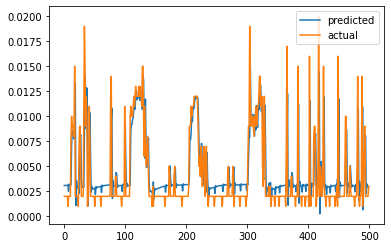

In [19]:
plt.plot(gru_outputs[0], label="predicted")
plt.plot(targets[0], label="actual")
plt.legend()

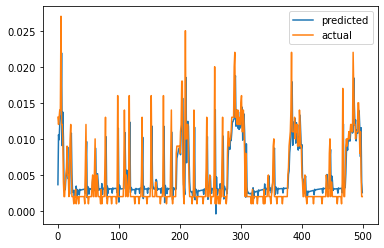

In [20]:
plt.plot(gru_outputs[1], label="predicted")
plt.plot(targets[1], label="actual")
plt.legend()

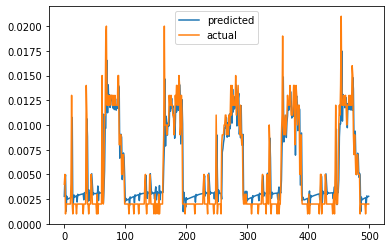

In [21]:
plt.plot(gru_outputs[2], label="predicted")
plt.plot(targets[2], label="actual")
plt.legend()

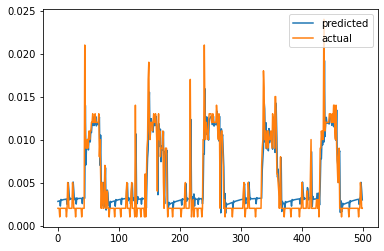

In [22]:
plt.plot(gru_outputs[3], label="predicted")
plt.plot(targets[3], label="actual")
plt.legend()

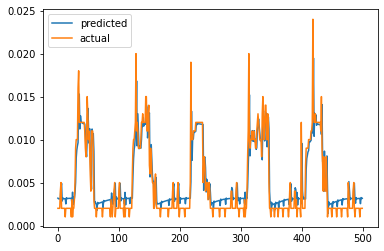

In [23]:
plt.plot(gru_outputs[4], label="predicted")
plt.plot(targets[4], label="actual")
plt.legend()

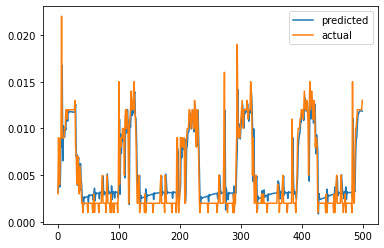

In [24]:
plt.plot(gru_outputs[5], label="predicted")
plt.plot(targets[5], label="actual")
plt.legend()